In [2]:
import torch 
import torchvision 
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

from torchinfo import summary 
from going_modular import data_setup, engine 
from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / "train" 
test_dir = data_20_percent_path / "test" 

In [6]:
# Setting up the EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad = False

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

In [9]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [11]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [12]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [13]:
from going_modular import engine 

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:36<05:26, 36.27s/it]

Epoch: 1 | train_loss: 0.9911 | train_acc: 0.5646 | test_loss: 0.7400 | test_acc: 0.9284


 20%|██        | 2/10 [01:07<04:24, 33.03s/it]

Epoch: 2 | train_loss: 0.7159 | train_acc: 0.8458 | test_loss: 0.5882 | test_acc: 0.9472


 30%|███       | 3/10 [01:38<03:47, 32.50s/it]

Epoch: 3 | train_loss: 0.5851 | train_acc: 0.8979 | test_loss: 0.4864 | test_acc: 0.9563


 40%|████      | 4/10 [02:07<03:05, 30.92s/it]

Epoch: 4 | train_loss: 0.4463 | train_acc: 0.9083 | test_loss: 0.4323 | test_acc: 0.9347


 50%|█████     | 5/10 [02:33<02:26, 29.31s/it]

Epoch: 5 | train_loss: 0.4309 | train_acc: 0.9083 | test_loss: 0.3882 | test_acc: 0.9443


 60%|██████    | 6/10 [03:00<01:53, 28.32s/it]

Epoch: 6 | train_loss: 0.4467 | train_acc: 0.8750 | test_loss: 0.3503 | test_acc: 0.9688


 70%|███████   | 7/10 [03:28<01:24, 28.31s/it]

Epoch: 7 | train_loss: 0.4264 | train_acc: 0.8729 | test_loss: 0.3247 | test_acc: 0.9625


 80%|████████  | 8/10 [03:58<00:57, 28.90s/it]

Epoch: 8 | train_loss: 0.3972 | train_acc: 0.9000 | test_loss: 0.3451 | test_acc: 0.9443


 90%|█████████ | 9/10 [04:27<00:28, 28.86s/it]

Epoch: 9 | train_loss: 0.3774 | train_acc: 0.8854 | test_loss: 0.3123 | test_acc: 0.9193


100%|██████████| 10/10 [04:54<00:00, 29.43s/it]

Epoch: 10 | train_loss: 0.3712 | train_acc: 0.8583 | test_loss: 0.2796 | test_acc: 0.9688


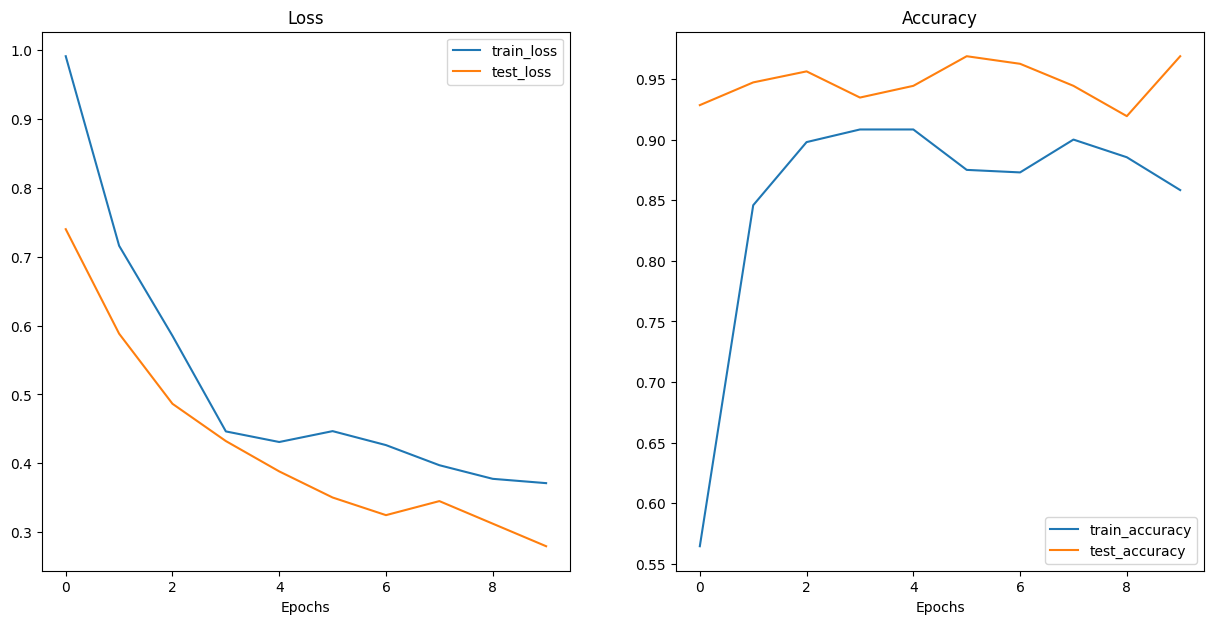

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [15]:
# Could perhaps use some data augmentation but won't do that now
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [16]:
from pathlib import Path 

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB
